In [1]:
%autosave 20

Autosaving every 20 seconds


In [2]:
# Author: Anderson Banihirwe
# License: MIT

![](http://deeplearning.net/tutorial/_images/mlp.png)

<h1 align="center"> Backpropagation and Multilayer Perceptron</h1>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Goals:
- Train a neural network with keras
- Implement Gradient Descent in NumPy
- Auto-differentiation with TensorFlow

# Dataset Introduction

We are going to use sklearn-digits: 10 classes Handwritten digits. For more details, go [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits).

Each datapoint is a 8x8 image of a digit:


|                   | Description   |
|-------------------|---------------|
| Classes           | 10            |
| Samples per class | ~180          |
| Samples total     | 1797          |
| Dimensionality    | 64            |
| Features          | integers 0-16 |

# Load the data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
import sklearn
import matplotlib as mpl

In [4]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The NumPy version is {}.'.format(np.__version__))
print('The Matplotlib version is {}.'.format(mpl.__version__))

The scikit-learn version is 0.18.1.
The NumPy version is 1.12.1.
The Matplotlib version is 2.0.1.


# Initialize Random Number Generator

Next we need to initialize the random number generator to a constant value (7).

*This is important to ensure that the results we achieve from this model can be achieved again precisely. It ensures that the stochastic process of training a neural network model can be reproduced.*

In [5]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [6]:
digits = load_digits()
print(digits.data.shape)
print(type(digits.data))

(1797, 64)
<class 'numpy.ndarray'>


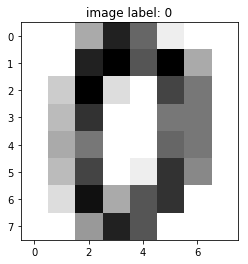

In [7]:
# Display some digit
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: {}".format(digits.target[0]))
plt.show()

# Data Preprocessing
We are going to do some preprocessing before training our classifier.
- Convert our data in an array using ```np.asarray()```.
- Split our dataset into training and testing sets with ```train_test_split()```
- Feature Scaling using standardization: This is used to bring all values into the same range. Feature standardization makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance. $$x'=\frac{x-\bar{x}}{\sigma}$$ Where $x$ is the original feature vector, ${\bar {x}}$ is the mean of that feature vector, and  $\sigma$  is its standard deviation.

 - The motivation behind this:  Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
 
 - Another reason why feature scaling is applied is that [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent) converges much faster with feature scaling than without it.



In [8]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Convert our data in array
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

# Split our data in training and testing set
X_train, X_test, y_train, y_test = train_test_split(
                        data, target, test_size=0.15, random_state=37)

# Feature Standardization mean = 0; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [9]:
print("Scaler Mean:\n\n", scaler.mean_)
print("\n\n", scaler.scale_)

Scaler Mean:

 [  0.00000000e+00   3.33333343e-01   5.27407408e+00   1.17962961e+01
   1.18000002e+01   5.62222242e+00   1.44444442e+00   1.88888893e-01
   0.00000000e+00   1.99629629e+00   1.05851851e+01   1.22555552e+01
   1.03740740e+01   8.01111126e+00   1.86296296e+00   1.59259260e-01
   0.00000000e+00   2.51851845e+00   1.02888889e+01   7.68148136e+00
   7.01481485e+00   7.62962961e+00   1.98518515e+00   8.14814791e-02
   0.00000000e+00   2.36666656e+00   9.35555553e+00   9.32222176e+00
   9.61481476e+00   7.44074059e+00   2.59629631e+00   0.00000000e+00
   0.00000000e+00   2.21481490e+00   7.57407427e+00   9.02962971e+00
   9.90740776e+00   8.47037029e+00   2.96296287e+00   0.00000000e+00
   1.11111114e-02   1.65925920e+00   7.06296301e+00   7.22592592e+00
   7.79629612e+00   8.07407379e+00   3.28888893e+00   3.33333351e-02
   0.00000000e+00   8.22222233e-01   7.58518505e+00   9.39259243e+00
   9.68518543e+00   8.65555573e+00   3.48888898e+00   1.92592591e-01
   0.00000000e+00  

Let's display one of the transformed sample (after feature standardization)

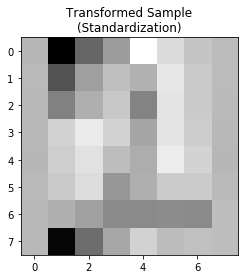

In [10]:
sample_index = 0
plt.imshow(X_train[sample_index].reshape(8, 8), cmap=plt.cm.gray_r, 
           interpolation="nearest")
plt.title("Transformed Sample\n(Standardization)");

The Scaler object make it possible to recover the original sample:

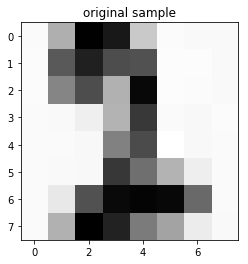

In [11]:
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8), 
           cmap=plt.cm.gray_r, interpolation="nearest")
plt.title("original sample");

In [12]:
print("X_train-shape --> {}".format(X_train.shape))
print("y_train-shape --> {}".format(y_train.shape))
print("X_test-shape  --> {}".format(X_test.shape))
print("y_test-shape  --> {}".format(y_test.shape))

X_train-shape --> (1527, 64)
y_train-shape --> (1527,)
X_test-shape  --> (270, 64)
y_test-shape  --> (270,)


# Feed Forward Neural Network with Keras

## Objectives
The objectives of this section include:
- Building and training a feedforward network using [**```Keras```**](https://keras.io/getting-started/sequential-model-guide/)
- Experimenting with different optimizers, activations, size of layers, initialization methods.

## 1.Keras Workflow

### Encode The Output Variable

When modeling multi-class classification problems using neural networks, it is good practice to reshape the output attribute from a vector that contains values for each class value to be a matrix with a boolean for each class value and whether or not a given instance has that class value or not.

This is called  ["one-hot-encoding"](https://en.wikipedia.org/wiki/One-hot) or creating dummy variables from a categorical variable.

For example, in this problem 10 class values are integer 0 to 9.
Let's print the first five observations from the training set labels.

In [13]:
y_train[:5]

array([2, 9, 5, 1, 6], dtype=int32)

As you can see, each label is just one integer value. We observe that the first entry is "Two". We can turn this into a one-hot encoded binary matrix for each data instance. We can do this by first encoding the labels consistently to integers using the scikit-learn [```class LabelEncoder```](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder). Then convert the vector of integers to a one hot encoding using the Keras function [```to_categorical()```](https://keras.io/utils/).


In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
endoded_Y = encoder.transform(y_train)
Y_train = to_categorical(endoded_Y)

Using TensorFlow backend.


In [15]:
Y_train[0:5]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

### Define The Neural Network Model

We can now build and train our feed-forward neural network using the high level API from keras. 

**Note:** The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in Scikit-learn. 

There is a [```KerasClassifier```](https://keras.io/scikit-learn-api/) class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.

Below is a function that will create a baseline feed-forward network for digit classification. It creates a simple fully connected network with one hidden layer that contains **100 neurons units**.

- First we define the model by stacking layers with the right dimensions
- then we define a loss function and plug the SGD optimizer
- then we feed the model the training data for fixed number of epochs


In [16]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
print('Keras version is {}.'.format(keras.__version__))

Keras version is 2.0.4.


In [17]:
# define some constants
N = X_train.shape[1]
H = 100
K = 10

In [18]:
X_train.shape[1]

64

In [19]:
# define baseline mlp model
def baseline_mlp_model():
    # Create model
    model = Sequential()
    model.add(Dense(units=H, input_dim=N))
    model.add(Activation("tanh"))
    model.add(Dense(K))
    model.add(Activation("softmax"))
    
    model.compile(optimizer=optimizers.SGD(lr=0.01),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
    

We can now create our KerasClassifier for use in scikit-learn.

We can also pass arguments in the construction of the KerasClassifier class that will be passed on to the ```fit()``` function internally used to train the neural network. Here, we pass the number of epochs as 20 and batch size as 32 to use when training the model. Debugging is also turned on when training by setting verbose to 1.

In [20]:
estimator = KerasClassifier(build_fn=baseline_mlp_model, 
                            epochs=15, batch_size= 32, verbose=2)

### Evaluate The Model with k-Fold Cross Validation

We can now evaluate the neural network model on our training data.

The scikit-learn has excellent capability to evaluate models using a suite of techniques. The gold standard for evaluating machine learning models is [**k-fold cross validation**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

First we can define the model evaluation procedure. Here, we set the number of folds to be 10 (an excellent default) and to shuffle the data before partitioning it.


In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

Now we can evaluate our model (estimator) on our dataset (X_train and Y_train) using a 10-fold cross validation procedure (kfold).



In [22]:
from time import time 
t0 = time()

results = cross_val_score(estimator, X_train, Y_train, cv=kfold)

tt = time() - t0

print("\n\nClassifier trained in {} seconds".format(round(tt, 3)))

Epoch 1/15
0s - loss: 2.1110 - acc: 0.2596
Epoch 2/15
0s - loss: 1.4683 - acc: 0.5725
Epoch 3/15
0s - loss: 1.1134 - acc: 0.7396
Epoch 4/15
0s - loss: 0.8966 - acc: 0.8075
Epoch 5/15
0s - loss: 0.7542 - acc: 0.8313
Epoch 6/15
0s - loss: 0.6524 - acc: 0.8509
Epoch 7/15
0s - loss: 0.5768 - acc: 0.8763
Epoch 8/15
0s - loss: 0.5184 - acc: 0.8976
Epoch 9/15
0s - loss: 0.4715 - acc: 0.9091
Epoch 10/15
0s - loss: 0.4332 - acc: 0.9189
Epoch 11/15
0s - loss: 0.4018 - acc: 0.9287
Epoch 12/15
0s - loss: 0.3754 - acc: 0.9361
Epoch 13/15
0s - loss: 0.3523 - acc: 0.9402
Epoch 14/15
0s - loss: 0.3325 - acc: 0.9451
Epoch 15/15
0s - loss: 0.3153 - acc: 0.9468
Epoch 1/15
0s - loss: 2.0544 - acc: 0.3030
Epoch 2/15
0s - loss: 1.4092 - acc: 0.6110
Epoch 3/15
0s - loss: 1.0623 - acc: 0.7600
Epoch 4/15
0s - loss: 0.8595 - acc: 0.8116
Epoch 5/15
0s - loss: 0.7273 - acc: 0.8428
Epoch 6/15
0s - loss: 0.6336 - acc: 0.8698
Epoch 7/15
0s - loss: 0.5636 - acc: 0.8927
Epoch 8/15
0s - loss: 0.5095 - acc: 0.9009
Epoch

In [23]:
print("Baseline MLP: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline MLP: 92.80% (1.13%)


Evaluating the model only takes approximately 38 seconds and returns an object that describes the evaluation of the 10 constructed models for each of the splits of the dataset.

Summary

In this post you discovered how to develop and evaluate a neural network using the Keras Python library for deep learning.

By completing this tutorial, you learned:

How to load data and make it available to Keras.
How to prepare multi-class classification data for modeling using one hot encoding.
How to use Keras neural network models with scikit-learn.
How to define a neural network using Keras for multi-class classification.
How to evaluate a Keras neural network model using scikit-learn with k-fold cross validation
Do you have any questions about deep learning with Keras or this post?

Ask your questions in the comments below and I will do my best to answer them.

In [24]:
# MLP for Digits Dataset with grid search via sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [25]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # Create model
    model = Sequential()
    model.add(Dense(units=100, input_dim=64, kernel_initializer=init, activation='relu'))
    model.add(Dense(units=64, kernel_initializer=init, activation='relu'))
    model.add(Dense(units=10, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy'])

    
    return model
    

In [26]:
# Create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Grid search epochs, batch_size and optimizer
optimizers = ['rmsprop', 'adam', 'sgd', 'adagrad']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [15, 30, 60]
batches = [16, 32, 64]
param_grid = dict(optimizer=optimizers, epochs=epochs, 
                  batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train)

In [29]:
# Summarize results
print("Best: %f using %s\n\n" % (grid_result.best_score_, 
                                       grid_result.best_params_))

Best: 0.981009 using {'epochs': 30, 'optimizer': 'rmsprop', 'batch_size': 64, 'init': 'glorot_uniform'}




In [30]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))

0.975769 (0.006483) with: {'epochs': 15, 'optimizer': 'rmsprop', 'batch_size': 16, 'init': 'glorot_uniform'}
0.973805 (0.004901) with: {'epochs': 15, 'optimizer': 'adam', 'batch_size': 16, 'init': 'glorot_uniform'}
0.921415 (0.010018) with: {'epochs': 15, 'optimizer': 'sgd', 'batch_size': 16, 'init': 'glorot_uniform'}
0.976424 (0.008335) with: {'epochs': 15, 'optimizer': 'adagrad', 'batch_size': 16, 'init': 'glorot_uniform'}
0.971840 (0.001852) with: {'epochs': 15, 'optimizer': 'rmsprop', 'batch_size': 16, 'init': 'normal'}
0.970530 (0.002778) with: {'epochs': 15, 'optimizer': 'adam', 'batch_size': 16, 'init': 'normal'}
0.659463 (0.055111) with: {'epochs': 15, 'optimizer': 'sgd', 'batch_size': 16, 'init': 'normal'}
0.966601 (0.003208) with: {'epochs': 15, 'optimizer': 'adagrad', 'batch_size': 16, 'init': 'normal'}
0.963982 (0.003339) with: {'epochs': 15, 'optimizer': 'rmsprop', 'batch_size': 16, 'init': 'uniform'}
0.968566 (0.003208) with: {'epochs': 15, 'optimizer': 'adam', 'batch_siz

In [31]:
# selected final model
selected_estimator = KerasClassifier(build_fn=create_model, epochs=30,
                                     batch_size=64, verbose = 2)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [32]:
from time import time 
t0 = time()

results = cross_val_score(selected_estimator, X_train, Y_train, cv=kfold)

tt = time() - t0

print("\n\nClassifier trained in {} seconds".format(round(tt, 3)))

Epoch 1/30
5s - loss: 1.8974 - acc: 0.5299
Epoch 2/30
0s - loss: 1.1687 - acc: 0.8567
Epoch 3/30
0s - loss: 0.5842 - acc: 0.9181
Epoch 4/30
0s - loss: 0.3165 - acc: 0.9468
Epoch 5/30
0s - loss: 0.1981 - acc: 0.9672
Epoch 6/30
0s - loss: 0.1357 - acc: 0.9795
Epoch 7/30
0s - loss: 0.0968 - acc: 0.9861
Epoch 8/30
0s - loss: 0.0692 - acc: 0.9918
Epoch 9/30
0s - loss: 0.0518 - acc: 0.9934
Epoch 10/30
0s - loss: 0.0373 - acc: 0.9959
Epoch 11/30
0s - loss: 0.0273 - acc: 0.9975
Epoch 12/30
0s - loss: 0.0208 - acc: 0.9992
Epoch 13/30
0s - loss: 0.0154 - acc: 1.0000
Epoch 14/30
0s - loss: 0.0115 - acc: 1.0000
Epoch 15/30
0s - loss: 0.0084 - acc: 1.0000
Epoch 16/30
0s - loss: 0.0062 - acc: 1.0000
Epoch 17/30
0s - loss: 0.0048 - acc: 1.0000
Epoch 18/30
0s - loss: 0.0034 - acc: 1.0000
Epoch 19/30
0s - loss: 0.0023 - acc: 1.0000
Epoch 20/30
0s - loss: 0.0017 - acc: 1.0000
Epoch 21/30
0s - loss: 0.0012 - acc: 1.0000
Epoch 22/30
0s - loss: 7.9457e-04 - acc: 1.0000
Epoch 23/30
0s - loss: 6.3813e-04 - a

## Compute predictions on Test set using ```model.predict_classes(...)```

In [49]:
selected_estimator.fit(X_train, y_train)

Epoch 1/30
5s - loss: 1.9201 - acc: 0.4623
Epoch 2/30
0s - loss: 1.0629 - acc: 0.8474
Epoch 3/30
0s - loss: 0.4568 - acc: 0.9234
Epoch 4/30
0s - loss: 0.2383 - acc: 0.9522
Epoch 5/30
0s - loss: 0.1493 - acc: 0.9725
Epoch 6/30
0s - loss: 0.1021 - acc: 0.9830
Epoch 7/30
0s - loss: 0.0732 - acc: 0.9876
Epoch 8/30
0s - loss: 0.0531 - acc: 0.9895
Epoch 9/30
0s - loss: 0.0400 - acc: 0.9915
Epoch 10/30
0s - loss: 0.0289 - acc: 0.9974
Epoch 11/30
0s - loss: 0.0207 - acc: 0.9987
Epoch 12/30
0s - loss: 0.0155 - acc: 0.9993
Epoch 13/30
0s - loss: 0.0113 - acc: 0.9993
Epoch 14/30
0s - loss: 0.0078 - acc: 1.0000
Epoch 15/30
0s - loss: 0.0058 - acc: 1.0000
Epoch 16/30
0s - loss: 0.0041 - acc: 1.0000
Epoch 17/30
0s - loss: 0.0026 - acc: 1.0000
Epoch 18/30
0s - loss: 0.0021 - acc: 1.0000
Epoch 19/30
0s - loss: 0.0013 - acc: 1.0000
Epoch 20/30
0s - loss: 9.2086e-04 - acc: 1.0000
Epoch 21/30
0s - loss: 6.2715e-04 - acc: 1.0000
Epoch 22/30
0s - loss: 5.2541e-04 - acc: 1.0000
Epoch 23/30
0s - loss: 3.4173

In [50]:
y_pred = selected_estimator.predict(X_test)

test acc: 0.9704


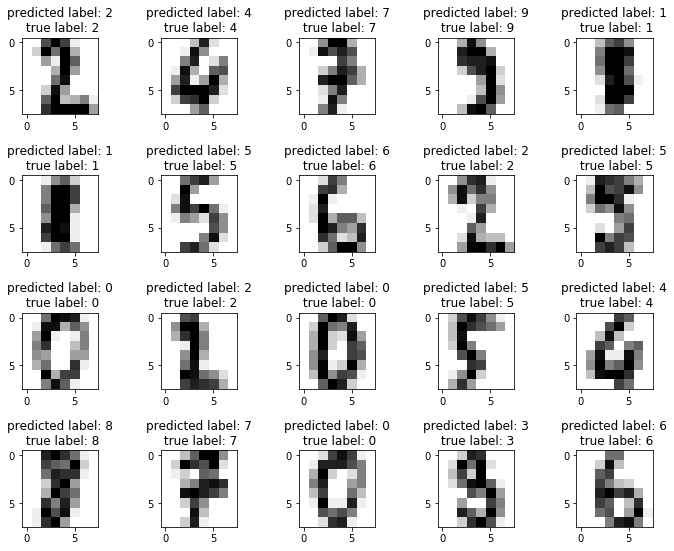

In [70]:
# Let's display the first inputs image, the predicted labels and the true labels
plt.figure(figsize=(12, 9))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.subplots_adjust(hspace = .8)
    plt.imshow(scaler.inverse_transform(X_test[i]).reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("predicted label: %d\n true label: %d"
              % (y_pred[i], y_test[i]))
    
print("test acc: %0.4f" % np.mean(y_pred == y_test))

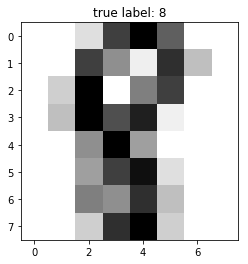

In [71]:
sample_idx = 42
plt.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("true label: %d" % y_test[sample_idx])


In [72]:
# Compute all probabilities for all samples in the test set at
# once:
probabilities = selected_estimator.predict_proba(X_test, verbose=0)

In [73]:
print("Predicted probability distribution for sample #42:")
for class_idx, prob in enumerate(probabilities[sample_idx]):
    print("%d: %0.5f" % (class_idx, prob))
print()
    
print("Likelihood of true class for sample #42:")
print(probabilities[sample_idx, y_test[sample_idx]])
print()

print("Average negative loglikelihood of the test set:")
Y_test = to_categorical(y_test)
loglikelihoods = np.sum(np.log(probabilities) * Y_test, axis=1)
print(-np.mean(loglikelihoods))


Predicted probability distribution for sample #42:
0: 0.00000
1: 0.00000
2: 0.00000
3: 0.00000
4: 0.00000
5: 0.00000
6: 0.00000
7: 0.00000
8: 0.61323
9: 0.00000

Likelihood of true class for sample #42:
0.613228

Average negative loglikelihood of the test set:
2.18923630504


In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')